In [1]:
#|default_exp resnet

## Resnets

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

AttributeError: module 'torch.backends.cuda' has no attribute 'is_available'

In [3]:
torch.cuda.is_available()

True

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStatsCB(append_stats, fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

## Making the model deeper

There are several ways in which the model accuracy can be improved.  One that seems obvious is to make the model deeper. Initially we will look at adding an additional conv layer to create 128 channels, and also making the first layer stride = 1

In [8]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [9]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.801,0.720,0,True
0.853,0.435,0,False
0.884,0.337,1,True
0.886,0.329,1,False
0.902,0.274,2,True
0.896,0.294,2,False
0.924,0.216,3,True
0.910,0.253,3,False
0.940,0.171,4,True
0.916,0.236,4,False


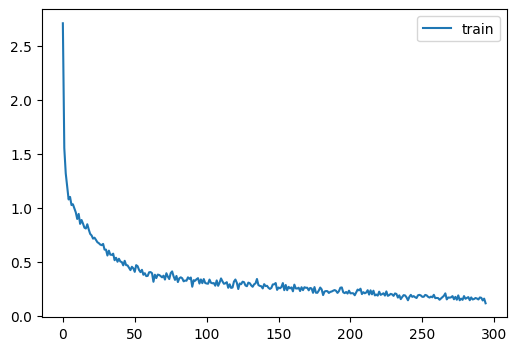

In [10]:
learn.fit(epochs)

## Skip Connections 

The ResNet (*residual network*) was introduced in 2015 by Kaiming He et al in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). The key idea is using a *skip connection* to allow deeper networks to train successfully.

<img width="700" src="images/att_00042.png">

The first builsing block for the skip connection network is the creation of a residual block that features both internal cnns and a pass through connection

In [15]:
#|export
def _conv_block(ni, nf, stride, ks=3, act=act_gr, norm=None):
    """ Note that the architectual choice being made here is that the first conv does the re-scaling
    and the second keeps the number of channels the same but reduces the resolution by using stride=2
    
    The pass through block uses a pooling layer to reduce the resolution and then a basic conv to change
    the number of channels to that required
    
    """
    return nn.Sequential(
        conv(ni, nf, stride=1, ks=3, act=act, norm=norm),
        conv(nf, nf, stride=stride, ks=3, act=None, norm=norm)
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        # Create the two convolution layers
        self.convs = _conv_block(ni, nf, stride, ks=ks, act=act, norm=norm)
        # Create the pass through layer.  Note that this can only be a complete pass of the input if ni=nf.
        # Where this is not the case a single conv is used (with no activation and kernel size of 1)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, stride=1, ks=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(kernel_size=2, ceil_mode=True)
        self.act = act()
        
    def forward(self, x):
        return self.act(self.convs(x)) + self.idconv(self.pool(x))
    

**Post-lesson update**: Piotr Czapla noticed that we forgot to include `norm=norm` in the call to `_conv_block` above, so the resnets in the lesson didn't have batchnorm in the resblocks! After fixing this, we discovered that initializing the `conv2` batchnorm weights to zero makes things worse in every model we tried, so we removed that. That init method was originally introduced to handle training extremely deep models (much deeper than we use here) -- it appears from this little test that it might be worse for less deep models.

In [30]:
def get_model(act=nn.ReLU, nfs=(8, 16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, nfs[0], stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], stride=2, act=act, norm=norm) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [31]:
model=get_model()

In [32]:
next(iter(model))

ResBlock(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (idconv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): ReLU()
)

In [33]:
type(next(iter(model))).__name__

'ResBlock'

Note that there is a method numel that will return the number of parameters of a layer.  This doesn't show up using the .tab method but is used below.  The cell below shows this working

In [36]:
block = next(iter(model))
param0 = next(iter(block.parameters()))
param0.numel()

72

It is worth noting that when a pytorch model is iterated then it yields the layers of the model at the level of the first children

In [34]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 28, 28])
ResBlock torch.Size([1024, 8, 28, 28]) torch.Size([1024, 16, 14, 14])
ResBlock torch.Size([1024, 16, 14, 14]) torch.Size([1024, 32, 7, 7])
ResBlock torch.Size([1024, 32, 7, 7]) torch.Size([1024, 64, 4, 4])
ResBlock torch.Size([1024, 64, 4, 4]) torch.Size([1024, 128, 2, 2])
ResBlock torch.Size([1024, 128, 2, 2]) torch.Size([1024, 256, 1, 1])
Flatten torch.Size([1024, 256, 1, 1]) torch.Size([1024, 256])
Linear torch.Size([1024, 256]) torch.Size([1024, 10])
BatchNorm1d torch.Size([1024, 10]) torch.Size([1024, 10])


The above information is usefult check that the model is behaving as expected.  Using a patch we will create a summay function that allows us to get the above information directly from a learner

A useful feature of the code below is the way that it detects whether it is in a notebook, and if so outputs the results in markdown format

In [53]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res, tot
        nparams = sum(o.numel() for o in mod.parameters())
        tot += nparams
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print(f'Total Parameters: {tot}')
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else:
        print(res)
        

In [54]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Total Parameters: 1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|712|
|ResBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3696|
|ResBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14560|
|ResBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|57792|
|ResBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|230272|
|ResBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|919296|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2560|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|


In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [57]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.768,0.859,0,True
0.853,0.486,0,False
0.884,0.378,1,True
0.874,0.356,1,False
0.908,0.277,2,True
0.891,0.308,2,False
0.928,0.213,3,True
0.921,0.238,3,False
0.947,0.165,4,True
0.925,0.217,4,False


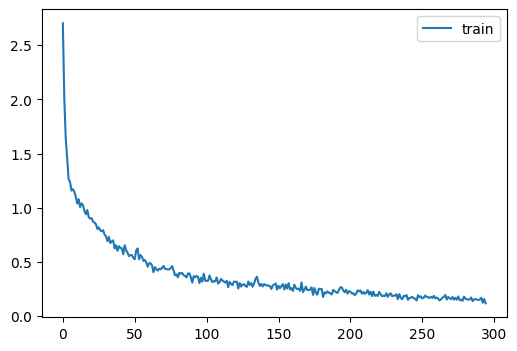

In [58]:
learn.fit(epochs)

In [60]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [61]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight ens_adv_inception_resnet_v2 gcresnet33ts gcresnet50t gluon_resnet18_v1b gluon_resnet34_v1b gluon_resnet50_v1b gluon_resnet50_v1c gluon_resnet50_v1d gluon_resnet50_v1s gluon_resnet101_v1b gluon_resnet101_v1c gluon_resnet101_v1d gluon_resnet101_v1s gluon_resnet152_v1b gluon_resnet152_v1c gluon_resnet152_v1d gluon_resnet152_v1s inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet10t resnet14t resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50d resnet50t resnet51q resnet61q resnet101 resnet

In [62]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)

In [63]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [ ]:
learn.fit(epochs)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()